**Titanic - Machine Learning from Disaster**

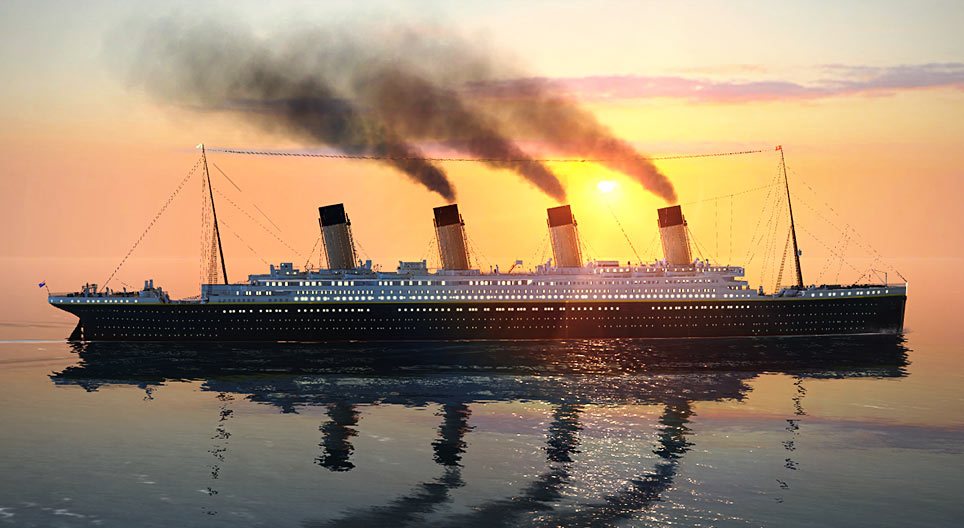

Tổng quan

Bộ dữ liệu được chia thành hai nhóm:

Tập huấn luyện (train.csv)

Tập kiểm tra (test.csv)

Tập huấn luyện được dùng để xây dựng mô hình học máy. Với tập này, chúng tôi cung cấp kết quả thực (còn gọi là “ground truth”) cho từng hành khách. Mô hình của bạn sẽ dựa trên các đặc trưng (features) như giới tính và hạng vé của hành khách. Bạn cũng có thể kỹ thuật đặc trưng (feature engineering) để tạo thêm các đặc trưng mới.

Tập kiểm tra được dùng để đánh giá mô hình trên dữ liệu chưa thấy. Với tập này, chúng tôi không cung cấp ground truth cho từng hành khách. Nhiệm vụ của bạn là dự đoán kết cục của họ. Với mỗi hành khách trong tập kiểm tra, hãy dùng mô hình đã huấn luyện để dự đoán họ có sống sót sau vụ đắm tàu Titanic hay không.


# Data Preprocessing

In [1]:
#import thư viện
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
print('Train set shape:', train_df.shape)
train_df.head()

Train set shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('Test set shape:', test_df.shape)
test_df.head()

Test set shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


+ PassengerId: ID duy nhất (không có giá trị dự đoán)

+ Survived: Target variable (0/1)

+ Pclass: Hạng vé (1, 2, 3)

+ Name: Tên hành khách

+ Sex: Giới tính (male/female)

+ Age: Tuổi

+ SibSp: Số anh chị em/vợ chồng đi cùng

+ Parch: Số cha mẹ/con cái đi cùng

+ Ticket: Số vé

+ Fare: Giá vé

+ Cabin: Số cabin

+ Embarked: Cảng lên tàu (C, Q, S)

### Missing Values

In [5]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
missing_percent = train_df.isna().mean() * 100
missing_summary = pd.DataFrame({
    'Missing Values': train_df.isna().sum(),
    'Percent (%)': missing_percent
})
print(missing_summary)

             Missing Values  Percent (%)
PassengerId               0     0.000000
Survived                  0     0.000000
Pclass                    0     0.000000
Name                      0     0.000000
Sex                       0     0.000000
Age                     177    19.865320
SibSp                     0     0.000000
Parch                     0     0.000000
Ticket                    0     0.000000
Fare                      0     0.000000
Cabin                   687    77.104377
Embarked                  2     0.224467


Xử lý missing values cho Age bằng median theo Sex và Pclass

In [7]:
age_missing_pattern = train_df.groupby(['Sex', 'Pclass'])['Age'].agg(['count', 'mean', 'median'])
print(age_missing_pattern)

               count       mean  median
Sex    Pclass                          
female 1          85  34.611765    35.0
       2          74  28.722973    28.0
       3         102  21.750000    21.5
male   1         101  41.281386    40.0
       2          99  30.740707    30.0
       3         253  26.507589    25.0


In [8]:
median_age = train_df.groupby(['Sex', 'Pclass'])['Age'].median()

# train: lấp bằng median theo nhóm
train_df['Age'] = train_df.groupby(['Sex', 'Pclass'])['Age'] \
                          .transform(lambda s: s.fillna(s.median()))

# test: dùng median đã fit từ train, fallback sang median toàn cục nếu thiếu key
global_median = train_df['Age'].median()
test_df['Age'] = test_df.apply(
    lambda row: row['Age']
    if pd.notna(row['Age'])
    else median_age.get((row['Sex'], row['Pclass']), global_median),
    axis=1,
)

In [9]:
train_df['Age'].isna().sum()
test_df['Age'].isna().sum()

np.int64(0)

Xử lý missing values cho Cabin

In [10]:
train_df['Cabin'].dropna().unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

+ Deck lấy chữ cái đầu (boong) từ Cabin và gán 'U' cho phần thiếu (không có cabin).

+ Sau đó sẽ one-hot encode Deck thành các cột Deck_A, Deck_B, ..., Deck_U.
+ Deck_U = 1 nghĩa là hành khách không có cabin (giữ lại thông tin quan trọng này).

In [11]:
for df in (train_df, test_df):
    df['Deck'] = df['Cabin'].str[0].fillna('U')

Loại bỏ cột Cabin

In [12]:
for dataset in (train_df, test_df):
    dataset.drop(columns='Cabin', inplace=True)

In [13]:
train_df[['Deck']].head()
train_df['Deck'].value_counts()

Deck
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

One-hot encode Deck để chuyển nhãn chữ cái thành nhiều cột nhị phân

In [14]:
deck_cols = pd.get_dummies(train_df['Deck'], prefix='Deck')
train_df = pd.concat(
    [train_df.drop(columns=['Deck'], errors='ignore'), deck_cols],
    axis=1,
)

test_deck_cols = pd.get_dummies(test_df['Deck'], prefix='Deck')
test_deck_cols = test_deck_cols.reindex(columns=deck_cols.columns, fill_value=0)

test_df = pd.concat(
    [test_df.drop(columns=['Deck'], errors='ignore'), test_deck_cols],
    axis=1,
)

Kiểm tra lại sau khi thực hiện One-hot encode Desk

In [15]:
train_df.filter(like='Deck_').head()

,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,False,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True


Xử lý missing values cho Embarked

In [16]:
most_freq_embarked = train_df['Embarked'].mode()[0]

for dataset in (train_df, test_df):
    dataset['Embarked'] = dataset['Embarked'].fillna(most_freq_embarked)


Xử lý missing values cho Fare

In [17]:
fare_by_pclass = train_df.groupby('Pclass')['Fare'].median()

mask = test_df['Fare'].isna()
test_df.loc[mask, 'Fare'] = test_df.loc[mask, 'Pclass'].map(fare_by_pclass)

# nếu nhóm Pclass không tồn tại (hiếm), fallback sang median toàn cục
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

Kiểm tra lại giá trị bị thiếu ở 2 tập

In [18]:
missing_summary = pd.DataFrame({
    'train_missing': train_df.isna().sum(),
    'test_missing': test_df.isna().sum(),
})
missing_summary

,train_missing,test_missing
Age,0,0.0
Deck_A,0,0.0
Deck_B,0,0.0
Deck_C,0,0.0
Deck_D,0,0.0
Deck_E,0,0.0
Deck_F,0,0.0
Deck_G,0,0.0
Deck_T,0,0.0
Deck_U,0,0.0


Kiểm tra trùng lặp trong dữ liệu

In [19]:
for name, df in [("train", train_df), ("test", test_df)]:
    duplicates = df.duplicated().sum()
    print(f"Số dòng trùng lặp trong {name}: {duplicates}")

Số dòng trùng lặp trong train: 0
Số dòng trùng lặp trong test: 0


Gán biến nhị phân cho cột Sex

In [20]:
train_df['Sex'].dropna().unique()

array(['male', 'female'], dtype=object)

In [21]:
sex_map = {'male': 1, 'female': 0}

for df in (train_df, test_df):
    df['Sex'] = df['Sex'].map(sex_map).astype(int)


In [22]:
train_df['Sex'].dropna().unique()

array([1, 0])

In [23]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Deck_A            bool
Deck_B            bool
Deck_C            bool
Deck_D            bool
Deck_E            bool
Deck_F            bool
Deck_G            bool
Deck_T            bool
Deck_U            bool
dtype: object

Xử lý kiểu dữ liệu cho Embarked

In [24]:
embarked_cols = pd.get_dummies(train_df['Embarked'], prefix='Embarked')
train_df = pd.concat([train_df.drop(columns='Embarked'), embarked_cols], axis=1)

test_embarked_cols = pd.get_dummies(test_df['Embarked'], prefix='Embarked')
test_embarked_cols = test_embarked_cols.reindex(columns=embarked_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns='Embarked'), test_embarked_cols], axis=1)


# Exploratory Data Analysis (EDA)

Khởi tạo & chuẩn bị dữ liệu

In [25]:
raw_train = train_df.copy()
raw_test = test_df.copy()

Tổng quan dữ liệu

In [26]:
display(raw_train.info())
display(raw_train.describe(include="all"))
display(raw_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Deck_A       891 non-null    bool   
 11  Deck_B       891 non-null    bool   
 12  Deck_C       891 non-null    bool   
 13  Deck_D       891 non-null    bool   
 14  Deck_E       891 non-null    bool   
 15  Deck_F       891 non-null    bool   
 16  Deck_G       891 non-null    bool   
 17  Deck_T       891 non-null    bool   
 18  Deck_U       891 non-null    bool   
 19  Embarked

None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891,891.000000,891.000000,891.000000,891.000000,891,891.000000,...,891,891,891,891,891,891,891,891,891,891
unique,NaN,NaN,NaN,891,NaN,NaN,NaN,NaN,681,NaN,...,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",NaN,NaN,NaN,NaN,347082,NaN,...,False,False,False,False,False,False,True,False,False,True
freq,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,7,NaN,...,832,858,859,878,887,890,687,723,814,646
mean,446.000000,0.383838,2.308642,NaN,0.647587,29.112424,0.523008,0.381594,NaN,32.204208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,0.477990,13.304424,1.102743,0.806057,NaN,49.693429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.000000,0.420000,0.000000,0.000000,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,0.000000,21.500000,0.000000,0.000000,NaN,7.910400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,1.000000,26.000000,0.000000,0.000000,NaN,14.454200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,1.000000,36.000000,1.000000,0.000000,NaN,31.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Deck_A       418 non-null    bool   
 10  Deck_B       418 non-null    bool   
 11  Deck_C       418 non-null    bool   
 12  Deck_D       418 non-null    bool   
 13  Deck_E       418 non-null    bool   
 14  Deck_F       418 non-null    bool   
 15  Deck_G       418 non-null    bool   
 16  Deck_T       418 non-null    int64  
 17  Deck_U       418 non-null    bool   
 18  Embarked_C   418 non-null    bool   
 19  Embarked

None

**Phân bố biến mục tiêu**

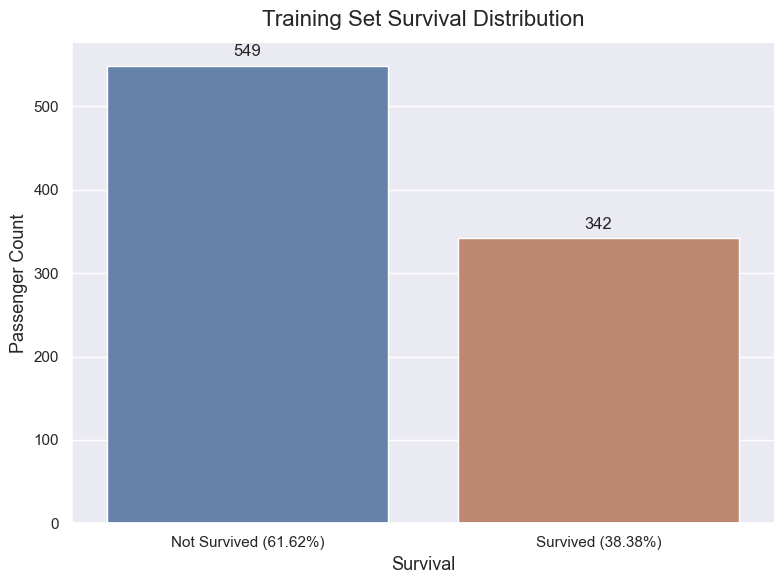

In [27]:
sns.set_theme(style="darkgrid")
counts = raw_train['Survived'].value_counts().reindex([0, 1])
labels = ['Not Survived', 'Survived']
percents = (counts / counts.sum() * 100).round(2)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=labels, y=counts.values, palette=['#5B80B5', '#C98266'], ax=ax)

for i, (count, pct) in enumerate(zip(counts.values, percents)):
    ax.text(i, count + 8, f'{count}', ha='center', va='bottom', fontsize=12)
ax.set_xticklabels([f'{label} ({pct:.2f}%)' for label, pct in zip(labels, percents)])
ax.set_title('Training Set Survival Distribution', fontsize=16, pad=12)
ax.set_xlabel('Survival', fontsize=13)
ax.set_ylabel('Passenger Count', fontsize=13)
sns.despine()
plt.tight_layout()
plt.show()


**Tỷ lệ sống sót theo boong**

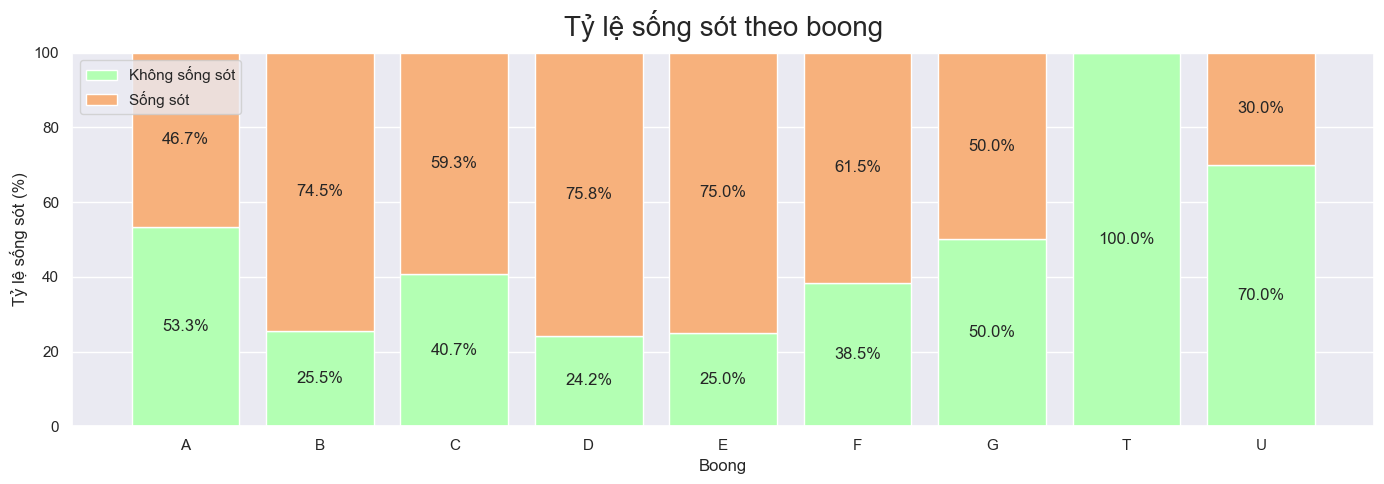

In [28]:
deck_cols = [c for c in train_df.columns if c.startswith('Deck_')]

deck_info = (
    train_df[['Survived'] + deck_cols]
    .assign(
        Deck=lambda df: df[deck_cols]
        .idxmax(axis=1)
        .str.replace('Deck_', '', regex=False)
    )
    [['Survived', 'Deck']]
)

survival_pct = (
    deck_info.groupby(['Deck', 'Survived'])
    .size()
    .unstack(fill_value=0)
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
    .reindex(sorted(deck_info['Deck'].unique()))  
)

fig, ax = plt.subplots(figsize=(14, 5))
bottom = np.zeros(len(survival_pct))
labels = {0: 'Không sống sót', 1: 'Sống sót'}
colors = {0: '#b3ffb3', 1: '#f7b17c'}

for surv in [0, 1]:
    ax.bar(
        survival_pct.index,
        survival_pct[surv],
        bottom=bottom,
        color=colors[surv],
        edgecolor='white',
        label=labels[surv]
    )
    bottom += survival_pct[surv].values

for idx, deck in enumerate(survival_pct.index):
    not_surv = survival_pct.loc[deck, 0]
    surv = survival_pct.loc[deck, 1]
    if not_surv > 0:
        ax.text(idx, not_surv / 2, f"{not_surv:.1f}%", ha='center', va='center')
    if surv > 0:
        ax.text(idx, not_surv + surv / 2, f"{surv:.1f}%", ha='center', va='center')

ax.set_ylabel('Tỷ lệ sống sót (%)', fontsize=12)
ax.set_xlabel('Boong', fontsize=12)
ax.set_title('Tỷ lệ sống sót theo boong', fontsize=20, pad=12)
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()


**Tương tác Sex × Pclass và tỷ lệ sống sót**

Mục tiêu: Xác nhận tương tác mạnh giữa giới tính và hạng vé.

Kỳ vọng: Nữ ở Pclass 1–2 sống sót rất cao; Nam ở Pclass 3 thấp nhất.

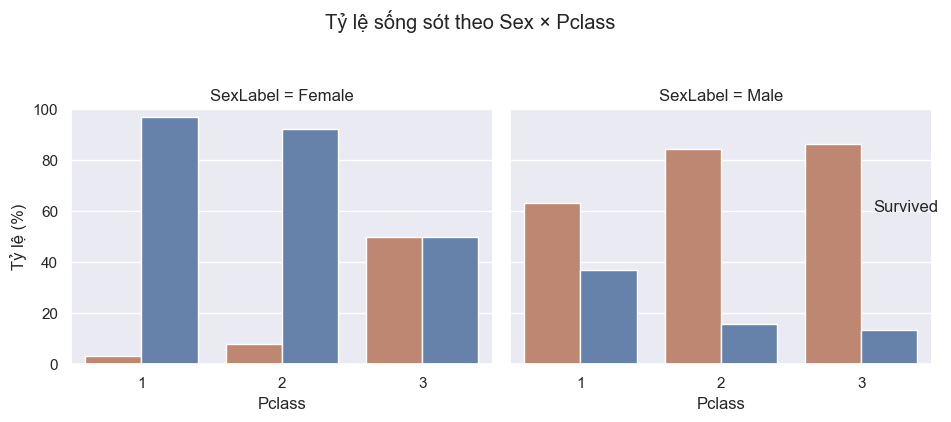

In [29]:
train_view = raw_train.copy()
train_view['SexLabel'] = train_view['Sex'].map({0: 'Female', 1: 'Male'})

ct = pd.crosstab(
    [train_view['SexLabel'], train_view['Pclass']],
    train_view['Survived'],
    normalize='index'
).mul(100)
pct = ct.reset_index().melt(
    id_vars=['SexLabel','Pclass'],
    var_name='Survived',
    value_name='pct'
)
g = sns.catplot(
    data=pct, x='Pclass', y='pct', hue='Survived', col='SexLabel',
    kind='bar', height=4, aspect=1.1, palette=['#C98266','#5B80B5'],
    legend=False
)
g.set_axis_labels('Pclass', 'Tỷ lệ (%)')
for ax in g.axes.flat:
    ax.set_ylim(0, 100)
g.add_legend(title='Survived')
plt.suptitle('Tỷ lệ sống sót theo Sex × Pclass', y=1.05)
plt.tight_layout()
plt.show()

**FarePerPerson (giá vé/người) và xác suất sống sót**

Mục tiêu: “Sức mua” sau khi điều chỉnh quy mô nhóm (FamilySize) thường mạnh hơn Fare thô.

Kỳ vọng: FarePerPerson cao → cơ hội sống sót cao, đặc biệt ở Pclass cao.

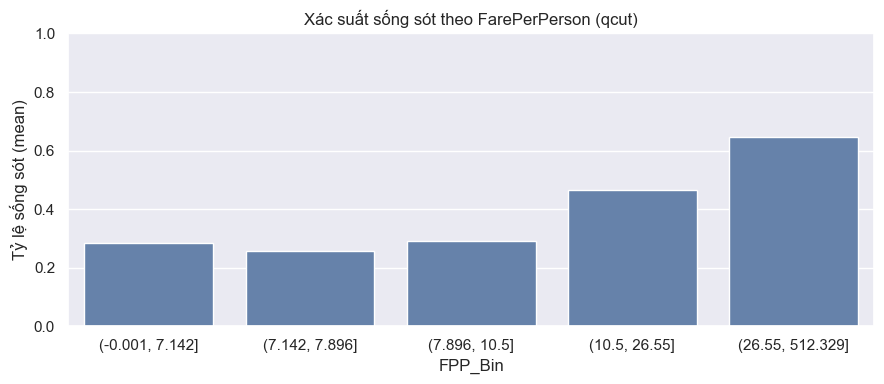

In [30]:
train_view = (raw_train
              .assign(FamilySize=lambda d: d['SibSp'] + d['Parch'] + 1)
              .assign(FarePerPerson=lambda d: d['Fare'] / d['FamilySize'].clip(lower=1))
              .loc[lambda d: d['FarePerPerson'].notna()]
              .assign(FPP_Bin=lambda d: pd.qcut(d['FarePerPerson'], q=5, duplicates='drop')))

fpp_surv = (train_view.groupby('FPP_Bin')['Survived']
            .mean().reset_index().rename(columns={'Survived':'SurvivalRate'}))

plt.figure(figsize=(9,4))
sns.barplot(data=fpp_surv, x='FPP_Bin', y='SurvivalRate', color='#5B80B5')
plt.ylim(0,1)
plt.ylabel('Tỷ lệ sống sót (mean)')
plt.title('Xác suất sống sót theo FarePerPerson (qcut)')
plt.tight_layout()
plt.show()

+ Hành khách trả nhiều tiền/người thường thuộc Pclass cao, gần boong/cửa thoát → ưu tiên cứu hộ.

+ Chia đều theo người giúp giảm nhiễu từ nhóm đi đông (Fare cao nhưng chia nhiều người → FPP thấp).

### Phân phối và ngoại lệ: Age, Fare, FamilySize

Mục tiêu: trực quan hóa phân phối và phát hiện ngoại lệ (đặc biệt là đuôi phải của Fare).
- Dùng các biến đã có sẵn trong flow (không lặp lại import).
- Histogram + KDE và boxplot cho `Age`, `Fare`, `FamilySize`.
- Kiểm tra outliers `Fare` bằng IQR và trực quan trên thang log.


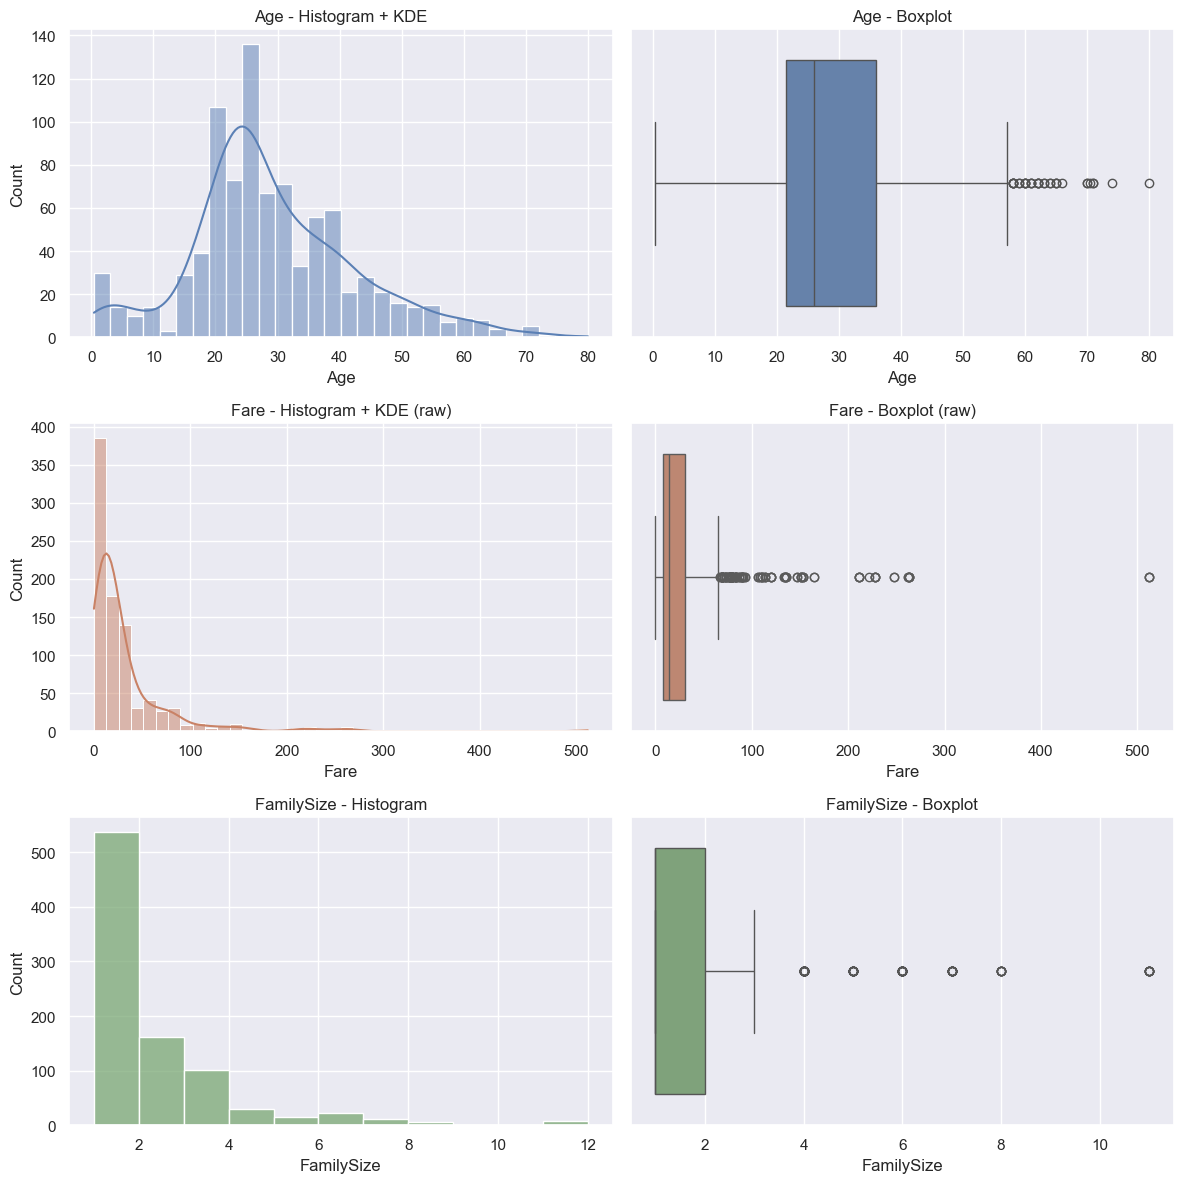

In [31]:
_df = raw_train if 'raw_train' in globals() else train_df.copy()

viz_df = (
    _df[['Age', 'Fare', 'SibSp', 'Parch']]
    .assign(FamilySize=lambda d: d['SibSp'] + d['Parch'] + 1)
)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Age
sns.histplot(viz_df['Age'].dropna(), kde=True, bins=30, ax=axes[0, 0], color='#5B80B5')
axes[0, 0].set_title('Age - Histogram + KDE')
axes[0, 0].set_xlabel('Age')

sns.boxplot(x=viz_df['Age'], ax=axes[0, 1], color='#5B80B5')
axes[0, 1].set_title('Age - Boxplot')
axes[0, 1].set_xlabel('Age')

# Fare
sns.histplot(viz_df['Fare'].dropna(), kde=True, bins=40, ax=axes[1, 0], color='#C98266')
axes[1, 0].set_title('Fare - Histogram + KDE (raw)')
axes[1, 0].set_xlabel('Fare')

sns.boxplot(x=viz_df['Fare'], ax=axes[1, 1], color='#C98266')
axes[1, 1].set_title('Fare - Boxplot (raw)')
axes[1, 1].set_xlabel('Fare')

# FamilySize
sns.histplot(viz_df['FamilySize'], bins=range(1, int(viz_df['FamilySize'].max()) + 2), ax=axes[2, 0], color='#7AA874')
axes[2, 0].set_title('FamilySize - Histogram')
axes[2, 0].set_xlabel('FamilySize')

sns.boxplot(x=viz_df['FamilySize'], ax=axes[2, 1], color='#7AA874')
axes[2, 1].set_title('FamilySize - Boxplot')
axes[2, 1].set_xlabel('FamilySize')

plt.tight_layout()
plt.show()


+ Age

    Phân phối một đỉnh, lệch phải nhẹ; tập trung khoảng 20–35 tuổi.
    Boxplot có vài điểm xa ở hai đầu nhưng không nhiều. Không cần xử lý outlier mạnh; có thể cân nhắc binning (qcut 4–5) cho mô hình tuyến tính.
+ Fare

    Rất lệch phải, đuôi dài; nhiều outlier rõ rệt vượt xa whisker.
    Nên log-transform (log1p(Fare)) hoặc winsorize/cap theo IQR hoặc p99/p99.5. Biểu đồ gợi ý log1p sẽ ổn định phương sai.
+ FamilySize

    Lệch phải mạnh; đa số là 1–2 người, số lượng lớn gia đình rất ít nhưng bị xem là outlier.
    Tiếp tục dùng IsAlone là hợp lý; cân nhắc cap FamilySize ở 6 hoặc phân nhóm Small/Medium/Big.

# Feature Engineering

**Title từ Name**

**Title** được tạo ra bằng cách trích xuất phần tiền tố (prefix) nằm trước thuộc tính Name. Theo biểu đồ dưới đây, có rất nhiều danh xưng (title) xuất hiện rất ít lần. Một số trong số đó có vẻ không chính xác và cần được thay thế.

Các danh xưng Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona được thay thế bằng Miss/Mrs/Ms vì tất cả đều là nữ.
Những giá trị như Mlle, Mme và Dona thực ra là tên của hành khách, nhưng lại bị phân loại thành danh xưng vì cột Name được tách bằng dấu phẩy.

Các danh xưng Dr, Col, Major, Jonkheer, Capt, Sir, Don và Rev được thay thế tương ứng bằng Dr/Military/Noble/Clergy vì những hành khách này có đặc điểm tương tự nhau.

Master là một danh xưng đặc biệt. Nó được dùng cho nam hành khách dưới 26 tuổi. Họ có tỷ lệ sống sót cao nhất trong số tất cả nam giới.

In [32]:
title_pattern = r",\s*([^\.]+)\."

female_titles = {"Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Countess", "Dona"}
military_titles = {"Col", "Major", "Capt"}
noble_titles = {"Sir", "Don", "Jonkheer"}
clergy_titles = {"Rev"}
doctor_titles = {"Dr"}  # giữ riêng vì hành khách bác sĩ thường có đặc điểm khác

def normalize_title(raw_title):
    if pd.isna(raw_title):
        return "Unknown"
    title = raw_title.strip()
    if title in female_titles:
        return "Miss/Mrs/Ms"
    if title in military_titles:
        return "Military"
    if title in noble_titles:
        return "Noble"
    if title in clergy_titles:
        return "Clergy"
    if title in doctor_titles:
        return "Dr"
    if title == "Master":
        return "Master"
    return "Other"

for dataset in (train_df, test_df):
    extracted = dataset["Name"].str.extract(title_pattern, expand=False)
    dataset["Title"] = extracted.apply(normalize_title)


In [33]:
title_cols = pd.get_dummies(train_df["Title"], prefix="Title")
train_df = pd.concat([train_df.drop(columns="Title"), title_cols], axis=1)

test_title_cols = pd.get_dummies(test_df["Title"], prefix="Title")
test_title_cols = test_title_cols.reindex(columns=title_cols.columns, fill_value=0)
test_df = pd.concat([test_df.drop(columns="Title"), test_title_cols], axis=1)

train_df.filter(like="Title_").sum()


Title_Clergy           6
Title_Dr               7
Title_Master          40
Title_Military         5
Title_Miss/Mrs/Ms    313
Title_Noble            3
Title_Other          517
dtype: int64

Loại bỏ cột Name

In [34]:
for dataset in (train_df, test_df):
    dataset.drop(columns='Name', inplace=True)

In [35]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Clergy', 'Title_Dr', 'Title_Master',
       'Title_Military', 'Title_Miss/Mrs/Ms', 'Title_Noble', 'Title_Other'],
      dtype='object')

**Tạo Feature Family Size**

Tổng thành viên đi chung

SibSp đếm số anh/chị/em và vợ/chồng đi cùng, Parch đếm số bố/mẹ/con. Hai cột đó chỉ cộng lại số “người thân đi cùng hành khách”. Để tính đúng quy mô gia đình trên vé, cần tính cả chính hành khách đó, vì họ cũng là một thành viên trong nhóm. Vì vậy chúng ta cộng thêm 1 để ra tổng số người trong “gia đình”/nhóm đi chung. Nếu không cộng thêm 1 thì một hành khách đi một mình sẽ có FamilySize = 0, trong khi trực giác và các nghiên cứu trước đây đều xem “một mình” là size 1.

In [36]:
for df in (train_df, test_df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

**Tạo thêm feature cho người đi một mình**

In [37]:
for dataset in (train_df, test_df):
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)

In [38]:
display(train_df[['FamilySize', 'IsAlone']].head())
display(test_df[['FamilySize', 'IsAlone']].head())

,FamilySize,IsAlone
0,2,0
1,2,0
2,1,1
3,2,0
4,1,1


,FamilySize,IsAlone
0,1,1
1,2,0
2,1,1
3,1,1
4,3,0


FarePerPerson: giá vé chia theo quy mô nhóm (FamilySize)

In [39]:
for df in (train_df, test_df):
    if 'FamilySize' not in df.columns:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FarePerPerson'] = df['Fare'] / df['FamilySize'].clip(lower=1)

print('Added FarePerPerson to train_df and test_df')
train_df[['Fare', 'FamilySize', 'FarePerPerson']].head()

Added FarePerPerson to train_df and test_df


,Fare,FamilySize,FarePerPerson
0,7.2500,2,3.62500
1,71.2833,2,35.64165
2,7.9250,1,7.92500
3,53.1000,2,26.55000
4,8.0500,1,8.05000


## Chuẩn bị dữ liệu và Lựa chọn đặc trưng

Phần này sẽ hướng dẫn các bước quan trọng để:
1. **Xử lý Outliers** - Loại bỏ hoặc giảm thiểu ảnh hưởng của giá trị ngoại lai
2. **Scaling/Normalization** - Chuẩn hóa dữ liệu cho các mô hình nhạy cảm với scale
3. **Feature Selection** - Lựa chọn các đặc trưng quan trọng nhất

### 1. Xử lý Outliers

**Tại sao cần xử lý outliers:**
- Outliers có thể làm méo phân phối và ảnh hưởng đến các mô hình nhạy cảm với khoảng cách (KNN, SVM, Logistic Regression)
- Fare có nhiều outliers rõ rệt (đã quan sát trong EDA)
- Age cũng có một số giá trị cực đoan

**Phương pháp:**
- **Log transformation** cho Fare (log1p để tránh log(0))
- **Winsorization** hoặc **capping** cho Age và FarePerPerson
- **IQR method** để xác định và xử lý outliers


In [40]:
# Xử lý outliers cho Fare bằng log transformation
# Log transformation giúp giảm độ lệch và ổn định phương sai

for df in (train_df, test_df):
    df['Fare_log'] = np.log1p(df['Fare'])  # log1p = log(1+x) để tránh log(0)
    
print("Đã tạo Fare_log từ Fare")
print(f"Skewness của Fare: {train_df['Fare'].skew():.2f}")
print(f"Skewness của Fare_log: {train_df['Fare_log'].skew():.2f}")

Đã tạo Fare_log từ Fare
Skewness của Fare: 4.79
Skewness của Fare_log: 0.39


In [41]:
# Xử lý outliers cho FarePerPerson bằng log transformation
for df in (train_df, test_df):
    df['FarePerPerson_log'] = np.log1p(df['FarePerPerson'])
    
print("Đã tạo FarePerPerson_log")
print(f"Skewness của FarePerPerson: {train_df['FarePerPerson'].skew():.2f}")
print(f"Skewness của FarePerPerson_log: {train_df['FarePerPerson_log'].skew():.2f}")

Đã tạo FarePerPerson_log
Skewness của FarePerPerson: 7.77
Skewness của FarePerPerson_log: 0.69


In [42]:
# Winsorization cho Age (giới hạn các giá trị cực đoan)
# Thay vì xóa outliers, chúng ta sẽ "cắt" chúng về giá trị ở percentile 1 và 99

def winsorize_column(df, col, lower=0.01, upper=0.99):
    """Winsorize một cột về percentile lower và upper"""
    lower_bound = df[col].quantile(lower)
    upper_bound = df[col].quantile(upper)
    return df[col].clip(lower=lower_bound, upper=upper_bound)

# Tạo Age_winsorized từ train_df để fit bounds
age_lower = train_df['Age'].quantile(0.01)
age_upper = train_df['Age'].quantile(0.99)

for df in (train_df, test_df):
    df['Age_winsorized'] = df['Age'].clip(lower=age_lower, upper=age_upper)

print(f"Age bounds: [{age_lower:.1f}, {age_upper:.1f}]")
print(f"Age range sau winsorization: [{train_df['Age_winsorized'].min():.1f}, {train_df['Age_winsorized'].max():.1f}]")

Age bounds: [1.0, 65.0]
Age range sau winsorization: [1.0, 65.0]


### 3. Phân tích tương quan và Feature Selection

**Mục tiêu:**
- Xác định các đặc trưng có tương quan cao với target (Survived)
- Loại bỏ các đặc trưng dư thừa (multicollinearity)
- Giảm số chiều để tránh overfitting và tăng tốc độ training


In [43]:
# Chuẩn bị dữ liệu cho phân tích
# Loại bỏ các cột không cần thiết: PassengerId, Ticket (chưa được xử lý)
feature_cols = [col for col in train_df.columns 
                if col not in ['PassengerId', 'Survived', 'Ticket']]

# Tạo correlation matrix với target
correlation_with_target = train_df[feature_cols + ['Survived']].corr()['Survived'].sort_values(ascending=False)

print("Tương quan với Survived (giảm dần):")
for col, corr in correlation_with_target.items():
    if col != 'Survived':
        print(f"{col:30s}: {corr:6.3f}")


Tương quan với Survived (giảm dần):
Title_Miss/Mrs/Ms             :  0.541
Fare_log                      :  0.330
FarePerPerson_log             :  0.299
Fare                          :  0.257
FarePerPerson                 :  0.222
Deck_B                        :  0.175
Embarked_C                    :  0.168
Deck_D                        :  0.151
Deck_E                        :  0.145
Deck_C                        :  0.115
Title_Master                  :  0.085
Parch                         :  0.082
Deck_F                        :  0.058
Deck_A                        :  0.022
FamilySize                    :  0.017
Deck_G                        :  0.016
Title_Dr                      :  0.008
Embarked_Q                    :  0.004
Title_Military                :  0.002
Title_Noble                   : -0.006
Deck_T                        : -0.026
SibSp                         : -0.035
Age_winsorized                : -0.059
Age                           : -0.060
Title_Clergy                

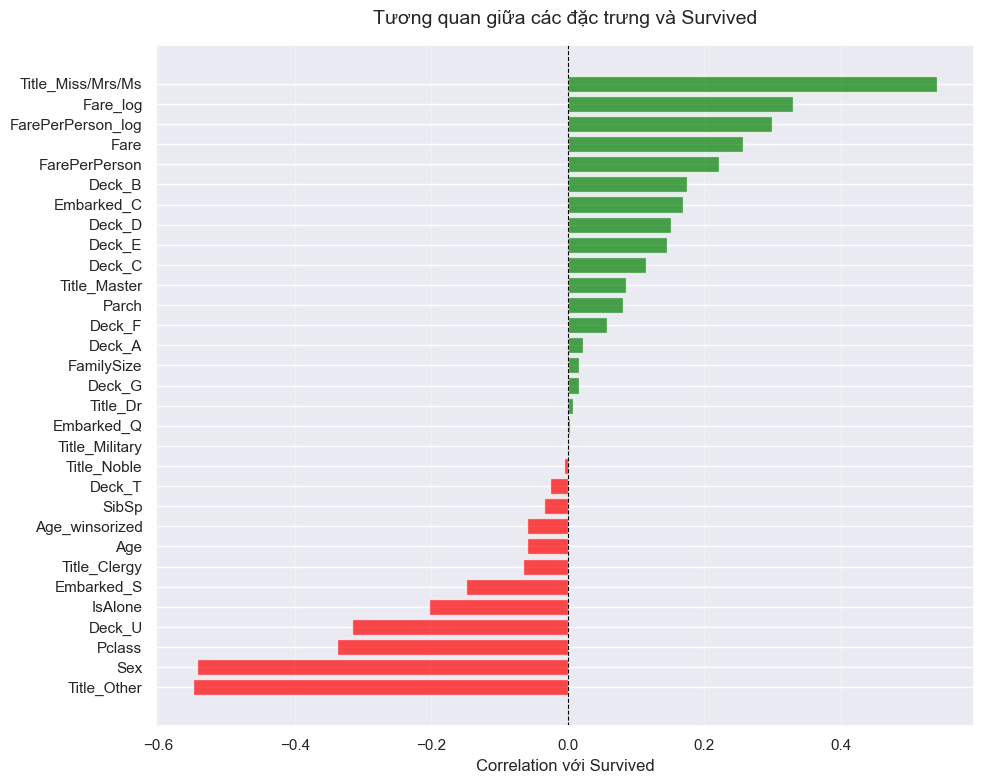


Các đặc trưng có |correlation| > 0.1 được coi là quan trọng:
Title_Other         -0.549199
Sex                 -0.543351
Title_Miss/Mrs/Ms    0.540769
Pclass              -0.338481
Fare_log             0.329862
Deck_U              -0.316912
FarePerPerson_log    0.298824
Fare                 0.257307
FarePerPerson        0.221600
IsAlone             -0.203367
Deck_B               0.175095
Embarked_C           0.168240
Deck_D               0.150716
Embarked_S          -0.149683
Deck_E               0.145321
Deck_C               0.114652
Name: Survived, dtype: float64


In [44]:
# Visualize correlation matrix với target
plt.figure(figsize=(10, 8))
corr_sorted = correlation_with_target.drop('Survived').sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in corr_sorted.values]

plt.barh(range(len(corr_sorted)), corr_sorted.values, color=colors, alpha=0.7)
plt.yticks(range(len(corr_sorted)), corr_sorted.index)
plt.xlabel('Correlation với Survived', fontsize=12)
plt.title('Tương quan giữa các đặc trưng và Survived', fontsize=14, pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCác đặc trưng có |correlation| > 0.1 được coi là quan trọng:")
important_features = corr_sorted[abs(corr_sorted) > 0.1]
print(important_features.sort_values(ascending=False, key=abs))


In [45]:
# Phân tích multicollinearity giữa các features
# Tính correlation matrix giữa các features (không bao gồm Survived)
feature_corr_matrix = train_df[feature_cols].corr().abs()

# Tìm các cặp features có correlation cao (> 0.8)
high_corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_val = feature_corr_matrix.iloc[i, j]
        if corr_val > 0.8:
            high_corr_pairs.append((
                feature_corr_matrix.columns[i],
                feature_corr_matrix.columns[j],
                corr_val
            ))

if high_corr_pairs:
    print("Các cặp features có correlation cao (> 0.8) - có thể dư thừa:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"{feat1:25s} <-> {feat2:25s}: {corr:.3f}")
else:
    print("Không có cặp features nào có correlation > 0.8")


Các cặp features có correlation cao (> 0.8) - có thể dư thừa:
Age                       <-> Age_winsorized           : 0.999
Sex                       <-> Title_Miss/Mrs/Ms        : 0.998
SibSp                     <-> FamilySize               : 0.891
Sex                       <-> Title_Other              : 0.867
Title_Miss/Mrs/Ms         <-> Title_Other              : 0.865
Fare                      <-> FarePerPerson            : 0.841
Fare_log                  <-> FarePerPerson_log        : 0.823


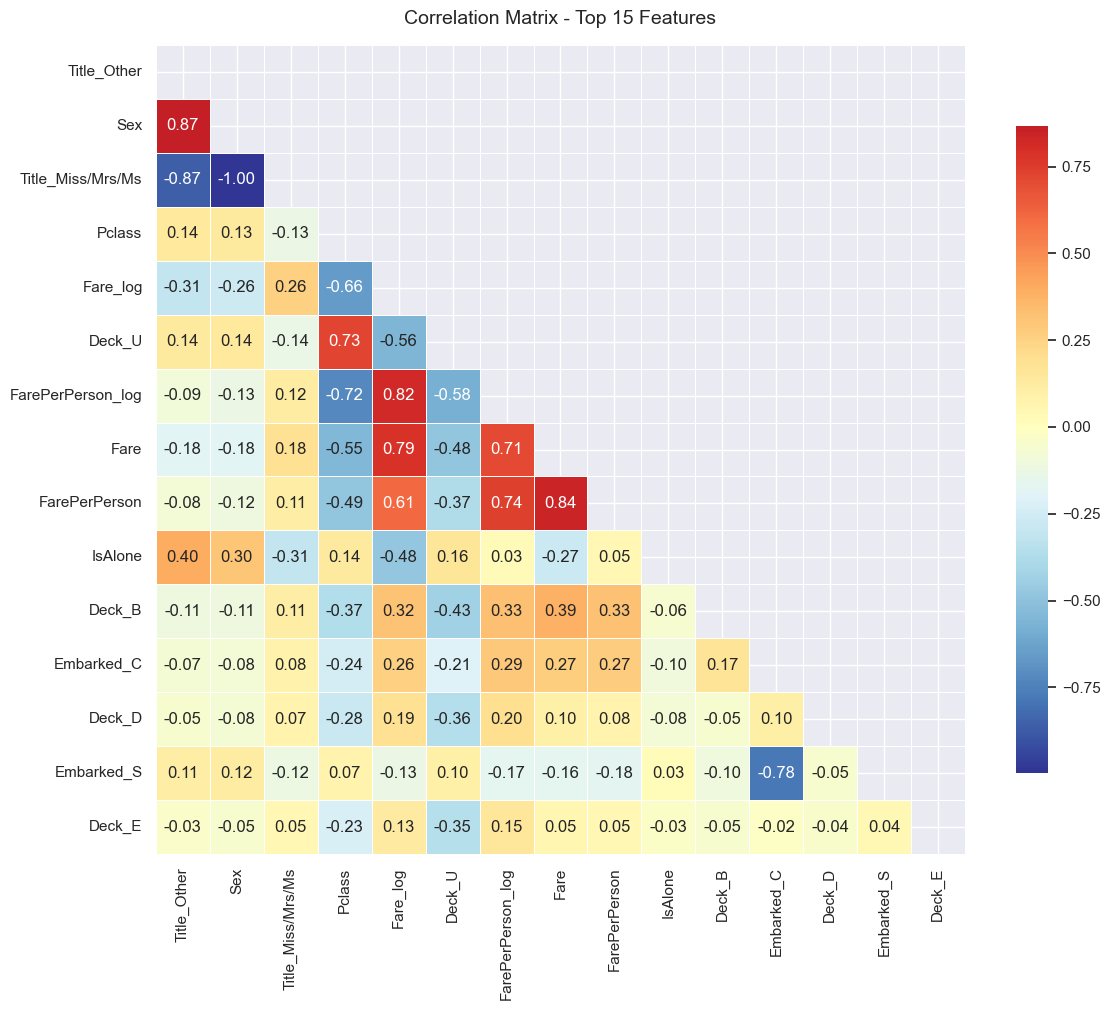

In [46]:
# Visualize correlation matrix giữa các features quan trọng
# Chọn top 15 features có correlation cao nhất với target
top_features = correlation_with_target.drop('Survived').abs().nlargest(15).index.tolist()

plt.figure(figsize=(12, 10))
corr_subset = train_df[top_features].corr()
mask = np.triu(np.ones_like(corr_subset, dtype=bool))  # Chỉ hiển thị tam giác dưới

sns.heatmap(corr_subset, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Top 15 Features', fontsize=14, pad=15)
plt.tight_layout()
plt.show()


### 4. Feature Selection bằng Machine Learning

Sử dụng các phương pháp ML-based để chọn features:
1. **Univariate Feature Selection** (SelectKBest với chi2 hoặc f_classif)
2. **Tree-based Feature Importance** (Random Forest, XGBoost)
3. **Recursive Feature Elimination (RFE)** với cross-validation


In [47]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

# Chuẩn bị dữ liệu
X = train_df[feature_cols].copy()
y = train_df['Survived'].copy()

# Chuyển đổi boolean columns thành int để tính toán
X = X.astype(float)

print(f"Số lượng features ban đầu: {X.shape[1]}")
print(f"Số lượng samples: {X.shape[0]}")

Số lượng features ban đầu: 31
Số lượng samples: 891


In [48]:
# Method 1: Univariate Feature Selection với f_classif (ANOVA F-test)
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X, y)

feature_scores_f = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector_f.scores_
}).sort_values('Score', ascending=False)

print("Top 20 features theo Univariate Selection (f_classif):")
print(feature_scores_f.head(20).to_string(index=False))

Top 20 features theo Univariate Selection (f_classif):
          Feature      Score
      Title_Other 383.945495
              Sex 372.405724
Title_Miss/Mrs/Ms 367.414594
           Pclass 115.031272
         Fare_log 108.541519
           Deck_U  99.253142
FarePerPerson_log  87.167879
             Fare  63.030764
    FarePerPerson  45.910184
          IsAlone  38.353651
           Deck_B  28.117228
       Embarked_C  25.895987
           Deck_D  20.663186
       Embarked_S  20.374460
           Deck_E  19.179221
           Deck_C  11.841661
     Title_Master   6.503635
            Parch   5.963464
     Title_Clergy   3.770523
              Age   3.166926


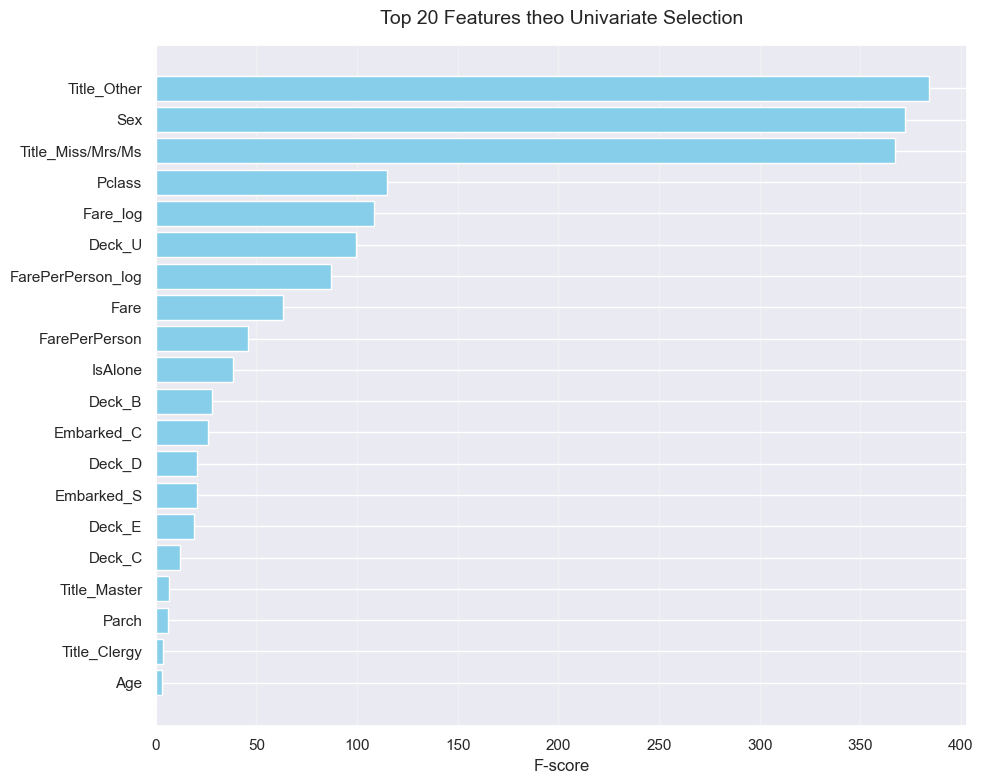

In [49]:
# Visualize feature scores
plt.figure(figsize=(10, 8))
top_n = 20
top_features_f = feature_scores_f.head(top_n)
plt.barh(range(len(top_features_f)), top_features_f['Score'].values, color='skyblue')
plt.yticks(range(len(top_features_f)), top_features_f['Feature'].values)
plt.xlabel('F-score', fontsize=12)
plt.title(f'Top {top_n} Features theo Univariate Selection', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [50]:
# Method 2: Tree-based Feature Importance (Random Forest)
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 features theo Random Forest Importance:")
print(feature_importance_rf.head(20).to_string(index=False))

Top 20 features theo Random Forest Importance:
          Feature  Importance
              Sex    0.117955
Title_Miss/Mrs/Ms    0.115482
      Title_Other    0.104728
    FarePerPerson    0.084828
              Age    0.081626
FarePerPerson_log    0.078717
   Age_winsorized    0.074134
         Fare_log    0.071688
             Fare    0.066734
           Pclass    0.043975
       FamilySize    0.034481
            SibSp    0.021391
           Deck_U    0.020262
            Parch    0.011342
       Embarked_S    0.010842
     Title_Master    0.009835
          IsAlone    0.008246
       Embarked_C    0.008109
           Deck_E    0.006503
           Deck_D    0.005646


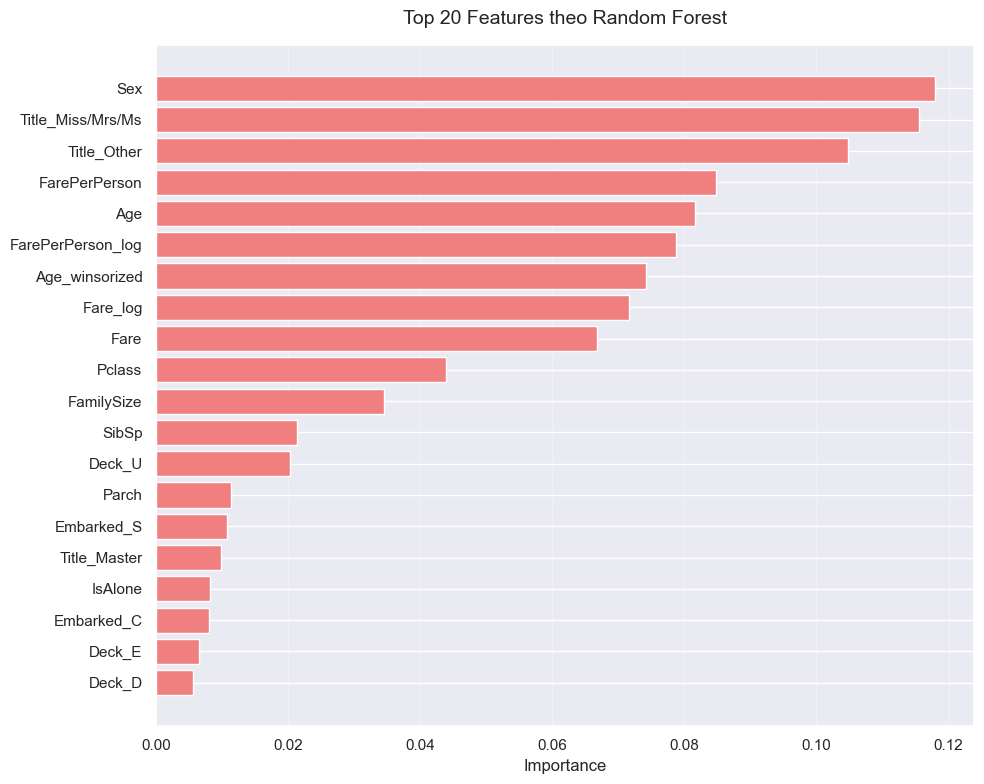

In [51]:
# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
top_n = 20
top_features_rf = feature_importance_rf.head(top_n)
plt.barh(range(len(top_features_rf)), top_features_rf['Importance'].values, color='lightcoral')
plt.yticks(range(len(top_features_rf)), top_features_rf['Feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Features theo Random Forest', fontsize=14, pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Method 3: Recursive Feature Elimination (RFE) với Random Forest
# RFE loại bỏ từng feature và đánh giá performance
rfe_rf = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10), 
             n_features_to_select=20,  # Chọn top 20 features
             step=1)
rfe_rf.fit(X, y)

feature_ranking_rfe = pd.DataFrame({
    'Feature': feature_cols,
    'RFE_Ranking': rfe_rf.ranking_,
    'Selected': rfe_rf.support_
}).sort_values('RFE_Ranking')

print("Top features được chọn bởi RFE:")
selected_features_rfe = feature_ranking_rfe[feature_ranking_rfe['Selected'] == True]
print(selected_features_rfe[['Feature', 'RFE_Ranking']].to_string(index=False))

Top features được chọn bởi RFE:
          Feature  RFE_Ranking
           Pclass            1
              Sex            1
              Age            1
            SibSp            1
            Parch            1
             Fare            1
       Embarked_C            1
           Deck_E            1
           Deck_U            1
       FamilySize            1
          IsAlone            1
    FarePerPerson            1
     Title_Master            1
Title_Miss/Mrs/Ms            1
       Embarked_S            1
       Embarked_Q            1
         Fare_log            1
FarePerPerson_log            1
   Age_winsorized            1
      Title_Other            1


In [53]:
# So sánh kết quả từ 3 phương pháp
# Tạo một bảng tổng hợp điểm số của từng feature

comparison_df = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [correlation_with_target[f] for f in feature_cols],
    'Univariate_Score': [selector_f.scores_[i] for i, f in enumerate(feature_cols)],
    'RF_Importance': rf.feature_importances_,
    'RFE_Selected': rfe_rf.support_
})

# Normalize scores để so sánh (0-1 scale)
comparison_df['Univariate_Norm'] = (comparison_df['Univariate_Score'] - comparison_df['Univariate_Score'].min()) / \
                                    (comparison_df['Univariate_Score'].max() - comparison_df['Univariate_Score'].min() + 1e-10)
comparison_df['RF_Norm'] = (comparison_df['RF_Importance'] - comparison_df['RF_Importance'].min()) / \
                           (comparison_df['RF_Importance'].max() - comparison_df['RF_Importance'].min() + 1e-10)
comparison_df['Correlation_Abs'] = comparison_df['Correlation'].abs()

# Tính điểm tổng hợp (weighted average)
comparison_df['Combined_Score'] = (
    comparison_df['Correlation_Abs'] * 0.3 +
    comparison_df['Univariate_Norm'] * 0.3 +
    comparison_df['RF_Norm'] * 0.4
)

comparison_df = comparison_df.sort_values('Combined_Score', ascending=False)

print("Top 25 features theo điểm tổng hợp (Correlation + Univariate + RF):")
display(comparison_df[['Feature', 'Correlation', 'RF_Importance', 'RFE_Selected', 'Combined_Score']].head(25))


Top 25 features theo điểm tổng hợp (Correlation + Univariate + RF):


,Feature,Correlation,RF_Importance,RFE_Selected,Combined_Score
1,Sex,-0.543351,0.117955,True,0.853989
22,Title_Miss/Mrs/Ms,0.540769,0.115482,True,0.840915
24,Title_Other,-0.549199,0.104728,True,0.819842
28,Fare_log,0.329862,0.071688,True,0.426641
29,FarePerPerson_log,0.298824,0.078717,True,0.424500
27,FarePerPerson,0.221600,0.084828,True,0.389850
5,Fare,0.257307,0.066734,True,0.352490
0,Pclass,-0.338481,0.043975,True,0.340186
2,Age,-0.059579,0.081626,True,0.296969
30,Age_winsorized,-0.059311,0.074134,True,0.271423


### 5. Xác định tập features cuối cùng

Dựa trên phân tích trên, chúng ta sẽ chọn các features:
1. **Có correlation cao với target** (|correlation| > 0.1)
2. **Được đánh giá cao bởi ML methods** (Univariate, RF)
3. **Không có multicollinearity cao** (loại bỏ một trong các cặp có correlation > 0.8)
4. **Domain knowledge** (Sex, Pclass, Age là quan trọng)


In [54]:
# Lấy top features từ combined score
top_n_features = 25
selected_by_score = comparison_df.head(top_n_features)['Feature'].tolist()


features_to_remove = []
if 'Fare' in selected_by_score and 'Fare_log' in selected_by_score:
    features_to_remove.append('Fare')
if 'FarePerPerson' in selected_by_score and 'FarePerPerson_log' in selected_by_score:
    features_to_remove.append('FarePerPerson')
if 'Age' in selected_by_score and 'Age_winsorized' in selected_by_score:
    features_to_remove.append('Age')

# Loại bỏ các features dư thừa
final_features = [f for f in selected_by_score if f not in features_to_remove]

# Đảm bảo các features quan trọng nhất luôn được bao gồm (nếu chưa có)
essential_features = ['Sex', 'Pclass', 'Age_winsorized', 'Fare_log']
for feat in essential_features:
    if feat not in final_features and feat in feature_cols:
        final_features.append(feat)

print(f"\nTổng số features được chọn: {len(final_features)}")
print("\nDanh sách features cuối cùng:")
for i, feat in enumerate(final_features, 1):
    print(f"{i:2d}. {feat}")


Tổng số features được chọn: 22

Danh sách features cuối cùng:
 1. Sex
 2. Title_Miss/Mrs/Ms
 3. Title_Other
 4. Fare_log
 5. FarePerPerson_log
 6. Pclass
 7. Age_winsorized
 8. Deck_U
 9. FamilySize
10. IsAlone
11. Embarked_C
12. Embarked_S
13. Deck_B
14. SibSp
15. Deck_E
16. Deck_D
17. Parch
18. Title_Master
19. Deck_C
20. Title_Clergy
21. Deck_F
22. Embarked_Q


## Chia tập dữ liệu thành Train/Validation/Test

**Mục đích:**
- **Train set**: Huấn luyện mô hình
- **Validation set**: Điều chỉnh hyperparameters và chọn mô hình tốt nhất
- **Test set**: Đánh giá cuối cùng trên dữ liệu chưa thấy

**Lưu ý quan trọng:**
- Tập `test.csv` ban đầu từ Kaggle không có labels, chỉ dùng để submission
- Chúng ta sẽ chia tập `train_df` (891 mẫu) thành 3 tập để phát triển mô hình
- Tỷ lệ chia thường dùng: 60% train, 20% validation, 20% test
- Sử dụng **stratified split** để đảm bảo phân bố của target được giữ nguyên trong cả 3 tập


In [55]:
from sklearn.model_selection import train_test_split

# Chuẩn bị dữ liệu với features đã chọn
X_final = train_df[final_features].copy()
y_final = train_df['Survived'].copy()

# Chuyển đổi boolean columns thành int (nếu cần)
X_final = X_final.astype(float)

print(f"Tổng số mẫu: {len(X_final)}")
print(f"Tổng số features: {len(final_features)}")
print(f"\nPhân bố target trong tập gốc:")
print(y_final.value_counts().sort_index())
print(f"\nTỷ lệ:")
print(y_final.value_counts(normalize=True).sort_index())

Tổng số mẫu: 891
Tổng số features: 22

Phân bố target trong tập gốc:
Survived
0    549
1    342
Name: count, dtype: int64

Tỷ lệ:
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [56]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_final, y_final, 
    test_size=0.2,           # 20% cho test set
    random_state=42,         
    stratify=y_final         
)

# Chia phần còn lại thành train và validation (60%/20% )
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,          
    random_state=42,
    stratify=y_temp
)
print("Kích thước các tập sau khi chia:")
print(f"Train set:      {X_train.shape[0]:4d} mẫu ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:4d} mẫu ({X_val.shape[0]/len(X_final)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:4d} mẫu ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"Tổng:           {len(X_final):4d} mẫu")

Kích thước các tập sau khi chia:
Train set:       534 mẫu (59.9%)
Validation set:  178 mẫu (20.0%)
Test set:        179 mẫu (20.1%)
Tổng:            891 mẫu


In [57]:
# Kiểm tra phân bố target trong từng tập
print("\nPhân bố target trong các tập:")
print("-" * 60)

for name, y_set in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    counts = y_set.value_counts().sort_index()
    proportions = y_set.value_counts(normalize=True).sort_index()
    print(f"\n{name} set:")
    print(f"  Sống sót (1): {counts.get(1, 0):4d} ({proportions.get(1, 0)*100:5.2f}%)")
    print(f"  Tử vong (0):   {counts.get(0, 0):4d} ({proportions.get(0, 0)*100:5.2f}%)")
    print(f"  Tổng:          {len(y_set):4d}")

print("Phân bố target được giữ nguyên nhờ stratified split")


Phân bố target trong các tập:
------------------------------------------------------------

Train set:
  Sống sót (1):  205 (38.39%)
  Tử vong (0):    329 (61.61%)
  Tổng:           534

Validation set:
  Sống sót (1):   68 (38.20%)
  Tử vong (0):    110 (61.80%)
  Tổng:           178

Test set:
  Sống sót (1):   69 (38.55%)
  Tử vong (0):    110 (61.45%)
  Tổng:           179
Phân bố target được giữ nguyên nhờ stratified split


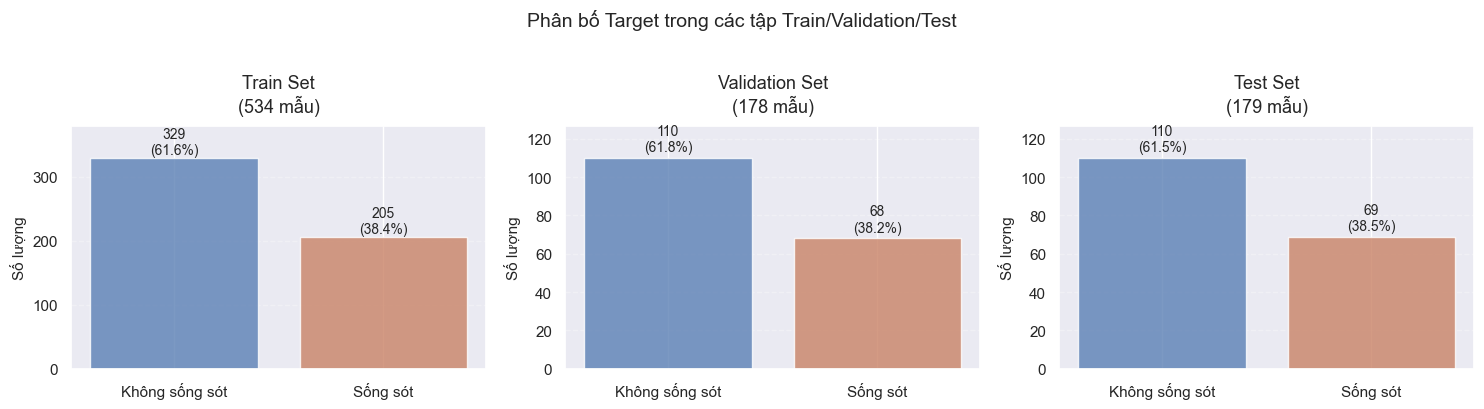

In [58]:
# Visualize phân bố target trong các tập
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, y_set, ax) in enumerate(zip(["Train", "Validation", "Test"], 
                                              [y_train, y_val, y_test], 
                                              axes)):
    counts = y_set.value_counts().reindex([0, 1], fill_value=0)
    labels = ['Không sống sót', 'Sống sót']
    colors = ['#5B80B5', '#C98266']
    
    bars = ax.bar(labels, counts.values, color=colors, alpha=0.8)
    ax.set_title(f'{name} Set\n({len(y_set)} mẫu)', fontsize=13, pad=10)
    ax.set_ylabel('Số lượng', fontsize=11)
    
    # Thêm nhãn số lượng và phần trăm
    total = counts.sum()
    for i, (bar, count) in enumerate(zip(bars, counts.values)):
        height = bar.get_height()
        pct = (count / total * 100) if total > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{int(count)}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    ax.set_ylim(0, max(counts.values) * 1.15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Phân bố Target trong các tập Train/Validation/Test', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Lưu ý:**
- Tập `test_df` ban đầu (418 mẫu) từ Kaggle sẽ được giữ lại để tạo submission file sau khi đã chọn mô hình tốt nhất
- Chúng ta sẽ dùng `X_test` và `y_test` để đánh giá mô hình cuối cùng trước khi submit
- Thứ tự sử dụng:
  1. **Train set**: Huấn luyện mô hình
  2. **Validation set**: Điều chỉnh hyperparameters
  3. **Test set**: Đánh giá cuối cùng
  4. **Kaggle test set**: Tạo submission file


# Model Training

In [59]:
# Tiện ích đánh giá mô hình
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier



def evaluate_model(trained_model, X_eval, y_eval, model_name="model"):
    y_pred = trained_model.predict(X_eval)
    y_proba = None
    try:
        y_proba = trained_model.predict_proba(X_eval)[:, 1]
    except Exception:
        try:
            # một số mô hình có decision_function
            scores = trained_model.decision_function(X_eval)
            # scale về [0,1] gần đúng để tính ROC-AUC
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        except Exception:
            y_proba = None

    metrics = {
        "model": model_name,
        "accuracy": accuracy_score(y_eval, y_pred),
        "precision": precision_score(y_eval, y_pred),
        "recall": recall_score(y_eval, y_pred),
        "f1": f1_score(y_eval, y_pred),
        "roc_auc": roc_auc_score(y_eval, y_proba) if y_proba is not None else np.nan,
    }
    return metrics


def cv_score(model, X, y, scoring="accuracy", n_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=None)
    return scores.mean(), scores.std()


In [60]:
# Tạo bản sao dữ liệu để đảm bảo dùng đúng splits đã tạo ở trên
X_tr, y_tr = X_train.copy(), y_train.copy()
X_vl, y_vl = X_val.copy(), y_val.copy()
X_ts, y_ts = X_test.copy(), y_test.copy()

# 1) Logistic Regression
logreg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42)
scaler = StandardScaler()
X_tr_lr = scaler.fit_transform(X_tr)
X_vl_lr = scaler.transform(X_vl)
X_ts_lr = scaler.transform(X_ts)

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
)

# 3) Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    random_state=42,
)

# 4) XGBoostClassifier
xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss', 
    random_state=42,
)

# Cross-validation (accuracy) trên Train cho từng mô hình
lr_cv_mean, lr_cv_std = cv_score(LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42),
                                 X_tr_lr, y_tr, scoring='accuracy', n_splits=5)
rf_cv_mean, rf_cv_std = cv_score(rf, X_tr, y_tr, scoring='accuracy', n_splits=5)
gb_cv_mean, gb_cv_std = cv_score(gb, X_tr, y_tr, scoring='accuracy', n_splits=5)
xgb_cv_mean, xgb_cv_std = cv_score(xgb, X_tr, y_tr, scoring='accuracy', n_splits=5)


print("CV Accuracy (mean ± std) trên Train:")
print(f"- LogisticRegression: {lr_cv_mean:.4f} ± {lr_cv_std:.4f}")
print(f"- RandomForest     : {rf_cv_mean:.4f} ± {rf_cv_std:.4f}")
print(f"- GradientBoosting : {gb_cv_mean:.4f} ± {gb_cv_std:.4f}")
print(f"- XGBoost          : {xgb_cv_mean:.4f} ± {xgb_cv_std:.4f}")
# Fit trên Train và đánh giá trên Validation
logreg.fit(X_tr_lr, y_tr)
rf.fit(X_tr, y_tr)
gb.fit(X_tr, y_tr)
xgb.fit(X_tr, y_tr)

val_results = []
val_results.append(evaluate_model(logreg, X_vl_lr, y_vl, model_name='LogisticRegression'))
val_results.append(evaluate_model(rf, X_vl, y_vl, model_name='RandomForest'))
val_results.append(evaluate_model(gb, X_vl, y_vl, model_name='GradientBoosting'))
val_results.append(evaluate_model(xgb, X_vl, y_vl, model_name='XGBoost'))

val_df = pd.DataFrame(val_results).sort_values(['f1','accuracy','roc_auc'], ascending=False)
print("\nKết quả Validation (sắp xếp theo F1, rồi Accuracy, ROC-AUC):")
display(val_df)


CV Accuracy (mean ± std) trên Train:
- LogisticRegression: 0.8202 ± 0.0477
- RandomForest     : 0.8051 ± 0.0483
- GradientBoosting : 0.8183 ± 0.0418
- XGBoost          : 0.8370 ± 0.0373

Kết quả Validation (sắp xếp theo F1, rồi Accuracy, ROC-AUC):


,model,accuracy,precision,recall,f1,roc_auc
2,GradientBoosting,0.848315,0.815385,0.779412,0.796992,0.894184
0,LogisticRegression,0.831461,0.771429,0.794118,0.782609,0.886564
3,XGBoost,0.837079,0.809524,0.750000,0.778626,0.886497
1,RandomForest,0.820225,0.764706,0.764706,0.764706,0.867045


In [61]:
# Đánh giá trên tập Test cho 3 mô hình và chọn mô hình tốt nhất theo F1

test_results = []
test_results.append(evaluate_model(logreg, X_ts_lr, y_ts, model_name='LogisticRegression'))
test_results.append(evaluate_model(rf, X_ts, y_ts, model_name='RandomForest'))
test_results.append(evaluate_model(gb, X_ts, y_ts, model_name='GradientBoosting'))
test_results.append(evaluate_model(xgb, X_ts, y_ts, model_name='XGBoost'))

test_metrics_df = pd.DataFrame(test_results).sort_values(['f1','accuracy','roc_auc'], ascending=False)
print("Kết quả Test (sắp xếp theo F1, rồi Accuracy, ROC-AUC):")
display(test_metrics_df)

best_name = test_metrics_df.iloc[0]['model']
print(f"\nMô hình tốt nhất trên Test: {best_name}")

best_model = {
    'LogisticRegression': logreg,
    'RandomForest': rf,
    'GradientBoosting': gb,
    'XGBoost': xgb,
}[best_name]

Kết quả Test (sắp xếp theo F1, rồi Accuracy, ROC-AUC):


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.798883,0.739130,0.739130,0.739130,0.848353
1,RandomForest,0.793296,0.750000,0.695652,0.721805,0.832411
3,XGBoost,0.776536,0.730159,0.666667,0.696970,0.834717
2,GradientBoosting,0.770950,0.712121,0.681159,0.696296,0.827997



Mô hình tốt nhất trên Test: LogisticRegression


Huấn luyện lại mô hình tốt nhất

In [62]:
# Ghép Train + Validation
X_train_full = pd.concat([X_tr, X_vl], axis=0)
y_train_full = pd.concat([y_tr, y_vl], axis=0)

from sklearn.pipeline import Pipeline

final_model = None
if best_name == 'LogisticRegression':
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, random_state=42)),
    ])
elif best_name == 'RandomForest':
    final_model = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
    )
elif best_name == 'GradientBoosting':
    final_model = GradientBoostingClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        random_state=42,
    )
elif best_name == 'XGBoost':
    final_model = XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
    )
else:
    raise ValueError(f"best_name không hợp lệ: {best_name}")

# Fit trên Train+Validation
final_model.fit(X_train_full, y_train_full)

train_metrics = evaluate_model(final_model, X_train_full, y_train_full, model_name=best_name)
test_metrics = evaluate_model(final_model, X_ts, y_ts, model_name=best_name)

print("Kết quả trên Train+Validation:")
display(pd.DataFrame([train_metrics]))
print("\nKết quả trên Test:")
display(pd.DataFrame([test_metrics]))

Kết quả trên Train+Validation:


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.832865,0.778986,0.787546,0.783242,0.886217



Kết quả trên Test:


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.815642,0.772727,0.73913,0.755556,0.8639


## Learning Curve (Đường cong học)

Mục tiêu: trực quan hóa hiện tượng underfitting/overfitting bằng cách quan sát độ chính xác (accuracy) trên tập huấn luyện và xác thực chéo khi tăng dần kích thước dữ liệu huấn luyện.

- Dùng StratifiedKFold để giữ phân bố lớp.
- Sử dụng Pipeline để tránh rò rỉ khi chuẩn hóa với Logistic Regression.
- Thang đo: accuracy.



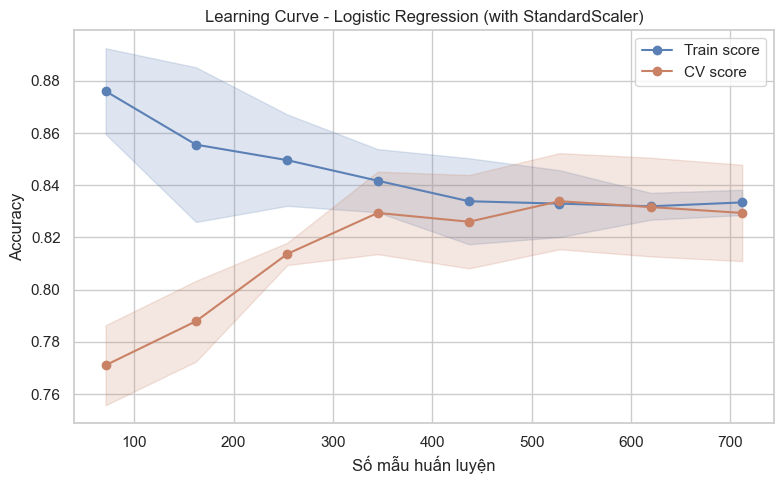

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline


def plot_learning_curve(model, X, y, title="Learning Curve", cv_splits=5, scoring="accuracy", n_points=8, random_state=42):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    train_sizes = np.linspace(0.1, 1.0, n_points)

    sizes, train_scores, valid_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=None,
        shuffle=True,
        random_state=random_state,
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    valid_std = valid_scores.std(axis=1)

    plt.figure(figsize=(8, 5))
    sns.set_theme(style="whitegrid")

    plt.plot(sizes, train_mean, "-o", color="#5B80B5", label="Train score")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, color="#5B80B5", alpha=0.2)

    plt.plot(sizes, valid_mean, "-o", color="#C98266", label="CV score")
    plt.fill_between(sizes, valid_mean - valid_std, valid_mean + valid_std, color="#C98266", alpha=0.2)

    plt.title(title)
    plt.xlabel("Số mẫu huấn luyện")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.tight_layout()
    plt.show()

pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=1.0, penalty="l2", solver="liblinear", max_iter=200, random_state=42)),
])

plot_learning_curve(
    model=pipeline_lr,
    X=X_final.astype(float),
    y=y_final,
    title="Learning Curve - Logistic Regression (with StandardScaler)",
    cv_splits=5,
    scoring="accuracy",
    n_points=8,
    random_state=42,
)

## Hyperparameter Tuning - Logistic Regression

- Sử dụng `Pipeline(StandardScaler -> LogisticRegression)` và `GridSearchCV` với `StratifiedKFold`.

- Tham số quét: `C` (logspace 1e-3..1e2), `penalty` (l1/l2), `class_weight` (None/balanced), `solver` (liblinear/saga).

- Tiêu chí chọn mô hình: refit theo `f1` (do dữ liệu mất cân bằng).

Best params (refit=f1):
{'clf__C': np.float64(5.623413251903491), 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Kết quả trên Validation:


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg_Tuned,0.831461,0.771429,0.794118,0.782609,0.879211



Kết quả trên Test:


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg_Tuned,0.798883,0.732394,0.753623,0.742857,0.84888



Top 10 cấu hình theo mean_test_f1:


,mean_test_f1,std_test_f1,mean_test_accuracy,param_clf__C,param_clf__penalty,param_clf__class_weight,param_clf__solver
72,0.779279,0.055263,0.825763,5.623413,l2,None,liblinear
28,0.777299,0.054616,0.812679,0.017783,l2,balanced,liblinear
98,0.777138,0.056891,0.827632,100.000000,l1,None,liblinear
97,0.776368,0.051731,0.823893,100.000000,l2,None,saga
89,0.776368,0.051731,0.823893,38.311868,l2,None,saga
99,0.776368,0.051731,0.823893,100.000000,l1,None,saga
44,0.776309,0.052679,0.816399,0.121153,l2,balanced,liblinear
82,0.775471,0.052354,0.825763,14.677993,l1,None,liblinear
36,0.775339,0.051025,0.814548,0.046416,l2,balanced,liblinear
40,0.775240,0.060960,0.822042,0.121153,l2,None,liblinear


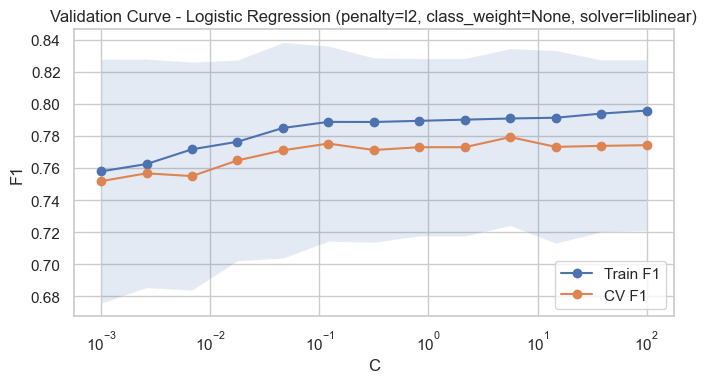

In [64]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dữ liệu tuning: dùng Train (giữ Validation/Test để đánh giá ngoài)
X_tune, y_tune = X_tr.copy(), y_tr.copy()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, random_state=42, n_jobs=None, solver='liblinear')),
])

param_grid = {
    'clf__C': np.logspace(-3, 2, 13),
    'clf__penalty': ['l2', 'l1'],
    'clf__class_weight': [None, 'balanced'],
    'clf__solver': ['liblinear', 'saga'],  # hỗ trợ l1/l2
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',
    cv=cv,
    n_jobs=None,
    verbose=0,
)

# Chạy grid search
gs.fit(X_tune, y_tune)

best_est = gs.best_estimator_
best_params = gs.best_params_
print("Best params (refit=f1):")
print(best_params)

# Đánh giá trên Validation và Test
val_metrics_tuned = evaluate_model(best_est, X_vl, y_vl, model_name='LogReg_Tuned')
test_metrics_tuned = evaluate_model(best_est, X_ts, y_ts, model_name='LogReg_Tuned')

print("\nKết quả trên Validation:")
display(pd.DataFrame([val_metrics_tuned]))
print("\nKết quả trên Test:")
display(pd.DataFrame([test_metrics_tuned]))

# Bảng top cấu hình theo f1
cv_results = pd.DataFrame(gs.cv_results_)
cols = ['mean_test_f1','std_test_f1','mean_test_accuracy','param_clf__C','param_clf__penalty','param_clf__class_weight','param_clf__solver']
print("\nTop 10 cấu hình theo mean_test_f1:")
display(cv_results.sort_values('mean_test_f1', ascending=False)[cols].head(10))

# Validation Curve cho C với penalty/class_weight/solver tốt nhất
best_pen = best_params['clf__penalty']
best_cw = best_params['clf__class_weight']
best_solver = best_params['clf__solver']

pipeline_fixed = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, random_state=42, penalty=best_pen, class_weight=best_cw, solver=best_solver)),
])

C_values = np.logspace(-3, 2, 13)
train_scores, val_scores = validation_curve(
    pipeline_fixed, X_tune, y_tune,
    param_name='clf__C', param_range=C_values,
    cv=cv, scoring='f1', n_jobs=None
)

plt.figure(figsize=(7,4))
plt.semilogx(C_values, train_scores.mean(axis=1), '-o', label='Train F1')
plt.semilogx(C_values, val_scores.mean(axis=1), '-o', label='CV F1')
plt.fill_between(C_values, val_scores.mean(axis=1)-val_scores.std(axis=1), val_scores.mean(axis=1)+val_scores.std(axis=1), alpha=0.15)
plt.xlabel('C'); plt.ylabel('F1'); plt.title('Validation Curve - Logistic Regression (penalty=%s, class_weight=%s, solver=%s)' % (best_pen, best_cw, best_solver))
plt.legend(); plt.tight_layout(); plt.show()

In [65]:
# Huấn luyện lại mô hình Logistic Regression tối ưu trên Train+Validation và tạo submission riêng
X_train_full = pd.concat([X_tr, X_vl], axis=0)
y_train_full = pd.concat([y_tr, y_vl], axis=0)

best_logreg = gs.best_estimator_
best_logreg.fit(X_train_full, y_train_full)

# Đánh giá lại trên Test
final_test_metrics = evaluate_model(best_logreg, X_ts, y_ts, model_name='LogReg_Tuned_FullTrain')
print("Kết quả trên Test sau khi fit Train+Validation:")
display(pd.DataFrame([final_test_metrics]))

# Submission file cho mô hình logreg tuned
kaggle_X = test_df[final_features].astype(float)
kaggle_pred = best_logreg.predict(kaggle_X)
submission_tuned = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': kaggle_pred.astype(int)})
submission_tuned.to_csv('submission_tuned.csv', index=False)
print("Đã ghi file submission_tuned.csv")


Kết quả trên Test sau khi fit Train+Validation:


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg_Tuned_FullTrain,0.821229,0.776119,0.753623,0.764706,0.864427


Đã ghi file submission_tuned.csv


Tuning lần 1

31/10/2025 - 9h00